In [1]:
# Imports

import numpy as np
import sys
sys.path.append('Knowledge/utils/')
import sklearn
import os
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
import keras
from keras import optimizers
from keras.losses import categorical_crossentropy as logloss
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from keras import backend as K



# use non standard flow_from_directory
from image_preprocessing_ver2 import ImageDataGenerator
# it outputs y_batch that contains onehot targets and logits

Using TensorFlow backend.


In [2]:
# Load logits saved from teacher

data_dir = os.path.join(os.getcwd(), 'data')

train_logits = np.load(os.path.join(data_dir, 'cifar10_train_logits.npy'), allow_pickle=True)[()]
val_logits = np.load(os.path.join(data_dir, 'cifar10_val_logits.npy'), allow_pickle=True)[()]

In [3]:
# Function to build and return student given dilation parameter

from keras import models, layers
from keras.initializers import lecun_normal

num_classes = 10

def build_student(dilation):
    
    if dilation > 1:
        dilation = 1
    if round(32 * dilation) == 0:
        dilation = 1/32

    initializer = lecun_normal(seed=0)

    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(32, 32, 3)))
    model.add(layers.Dense(int(round(dilation*256)), kernel_initializer=initializer))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(int(round(dilation*256)), kernel_initializer=initializer))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(10, kernel_initializer=initializer))
    model.add(layers.Activation('softmax'))
    
    return model

In [4]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

data_generator = ImageDataGenerator(data_format='channels_last', rescale=1/255)

batch_size = 128
epochs=75
data_dir = r'C:\Users\ender\Pictures\data'
train_generator = data_generator.flow_from_directory(os.path.join(data_dir, 'cifar10\\train'), train_logits, target_size=(32, 32), color_mode='rgb', batch_size=batch_size)
val_generator = data_generator.flow_from_directory(os.path.join(data_dir, 'cifar10\\test'), val_logits, target_size=(32, 32), color_mode='rgb', batch_size=batch_size)

def train_student(student):
    student.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=[accuracy])
    
    student.fit_generator(
        train_generator,
        epochs=epochs,
        steps_per_epoch=50000/batch_size,
        verbose=0,
        validation_data=val_generator,
        validation_steps=25,
        callbacks=[
                EarlyStopping(monitor='val_loss', patience=5, min_delta=0.005)
            ]
        )
    return student

Found 50000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [5]:
# Distillation loss (soft targets and hard targets)

from keras.losses import categorical_crossentropy as logloss
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from keras import backend as K

def distillation_loss(y_true, y_pred, hard_loss_weight, temp):
    y_true, logits = y_true[:, :10], y_true[:, 10:]
    
    y_soft = K.softmax(logits / temp)
    
    y_pred, y_pred_soft = y_pred[:, :10], y_pred[:, 10:]
    
    return hard_loss_weight * logloss(y_true, y_pred) + logloss(y_soft, y_pred_soft)
    

In [6]:
val_generator_no_shuffle = data_generator.flow_from_directory(
    os.path.join(data_dir, 'cifar10\\test'), val_logits,
    target_size=(32, 32),
    batch_size=batch_size, color_mode='rgb', shuffle=False
)

Found 10000 images belonging to 10 classes.


In [7]:
def distill(dilation, temp, weight):
    def accuracy(y_true, y_pred):
        y_true = y_true[:, :10]
        y_pred = y_pred[:, :10]
        return categorical_accuracy(y_true, y_pred)

    def top_5_accuracy(y_true, y_pred):
        y_true = y_true[:, :10]
        y_pred = y_pred[:, :10]
        return top_k_categorical_accuracy(y_true, y_pred)

    def categorical_crossentropy(y_true, y_pred):
        y_true = y_true[:, :10]
        y_pred = y_pred[:, :10]
        return logloss(y_true, y_pred)

    def soft_logloss(y_true, y_pred):     
        logits = y_true[:, 10:]
        y_soft = K.softmax(logits/temp)
        y_pred_soft = y_pred[:, 10:]    
        return logloss(y_soft, y_pred_soft)
    
    student = build_student(dilation)
    # Remove softmax
    student.pop()
    # Get student logits and class probabilities
    logits = student.layers[-1].output
    probabilities = layers.Activation('softmax')(logits)

    # Apply temperature to get softed probabilities
    # Temps of 2.5-4 "worked significantly better" than other temps on networks with 30 units per layer
    logits_T = layers.Lambda(lambda x: x / temp)(logits)
    probabilities_T = layers.Activation('softmax')(logits_T)

    from keras.optimizers import SGD, RMSprop

    from keras.models import Model
    output = layers.concatenate([probabilities, probabilities_T])
    model = Model(student.input, output)
    
    model.compile(
        optimizer='adam',
        loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, weight, temp),
        metrics=[accuracy, top_5_accuracy, categorical_crossentropy, soft_logloss])

    from keras.callbacks import ReduceLROnPlateau, EarlyStopping
    history = model.fit_generator(
        train_generator,
        epochs=25,
        steps_per_epoch=50000/batch_size,
        verbose=0,
        validation_data=val_generator,
        validation_steps=25,
        callbacks=[
                EarlyStopping(monitor='val_loss', patience=5, min_delta=0.005)
            ])

    results = model.evaluate_generator(val_generator_no_shuffle, 50000/batch_size)
    return results, model

In [8]:
# Load data for non-distilled training
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [9]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
def train(dilation):
    student = build_student(dilation)
    student.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
    history = student.fit(
        x_train,
        y_train,
        epochs=25,
        verbose=0,
        validation_data=(x_test, y_test),
        callbacks=[
                EarlyStopping(monitor='val_loss', patience=5, min_delta=0.005)
            ])
    results = student.evaluate(x_test, y_test)
    return results

In [15]:
dilation_accuracies = []
reg_accuracies = []
for dilation in np.linspace(0.125, 1, 8):
    d_accuracy, model = distill(dilation, temp=25, weight=0.2)
    dilation_accuracies.append((dilation, d_accuracy))
    acc = train(dilation)
    reg_accuracies.append((dilation, acc))
dilation_accuracies = np.asarray(dilation_accuracies)
reg_accuracies = np.asarray(reg_accuracies)
np.save('data/dilation_accuracies.npy', dilation_accuracies)
np.save('data/reg_accuracies.npy', reg_accuracies)

10000/10000 [==============================] - 2s 195us/step


In [12]:
a = []
for t in [1, 5, 10, 25, 50, 100]:
    d_accuracy, model = distill(0.5, t, 0.07)
    a.append((t, d_accuracy))

KeyboardInterrupt: 

In [11]:
d_accuracy

[1.2077606916427612,
 0.3610685467720032,
 0.934415340423584,
 9.437540054321289,
 1.207494854927063]

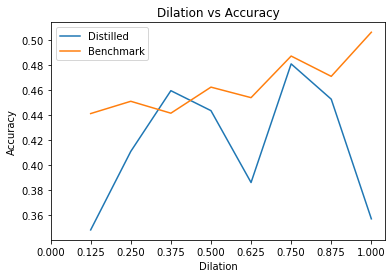

In [16]:
import matplotlib.pyplot as plt
import numpy as np

d_accuracies = np.load('data/dilation_accuracies.npy', allow_pickle=True)
dilation_x = d_accuracies[:, 0]
dilation_y = list(map(lambda x: x[1][1], d_accuracies))

reg_accuracies = np.load('data/reg_accuracies.npy', allow_pickle=True)
reg_x = reg_accuracies[:, 0]
reg_y = list(map(lambda x: x[1][1], reg_accuracies))

plt.plot(dilation_x, dilation_y, label='Distilled')
plt.plot(reg_x, reg_y, label='Benchmark')
plt.title('Dilation vs Accuracy')
# for i, temp in enumerate(weight_accuracies):
#     plt.annotate(f'({weight_accuracies[i, 0]}, {accuracies[i]:.2f})', (weight_accuracies[i, 0], accuracies[i]))
plt.xlabel('Dilation')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(np.linspace(0, 1, 9))
plt.savefig('cifar2_dilation_v_accuracy.png')